# Hypothesis Testing with Insurance Data (Core)
---

Author: Jackson Muehlbauer

Date: 3/8/23

In [1]:
# imports 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [28]:
# check for outliers

def drop_outliers(data):
    z_scores = stats.zscore(data)
    outliers = np.abs(z_scores) > 3
    n_out = np.sum(outliers)
    print(f'Number of instances: {len(data)}')
    print(f'Number of Outliers: {n_out}')
    if n_out > 0:
        ans = input('Drop outliers (y, n):')
        if ans == 'y':
            data = data[(np.abs(z_scores) < 3)]
            print(f'Number of instances after drop: {len(data)}')
    
    return data

In [2]:
# load data
df = pd.read_csv('Data/insurance - insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


**Questions to Answer:**

- Q1. Do smokers have higher insurance charges than non-smokers?
- Q2. Are men more likely to smoke than women?
- Q3. Do different regions have different charges, on average?

**For each question, make sure to:**

1. State your Null Hypothesis and Alternative Hypothesis
2. Select the correct test according to the data type and number of samples
3. Test the assumptions of your selected test.
4. Execute the selected test, or the alternative test (if you do not meet the assumptions)
5. Interpret your p-value and reject or fail to reject your null hypothesis 
6. Show a supporting visualization that helps display the result

## Do smokers have higher insurance charges than non-smokers?

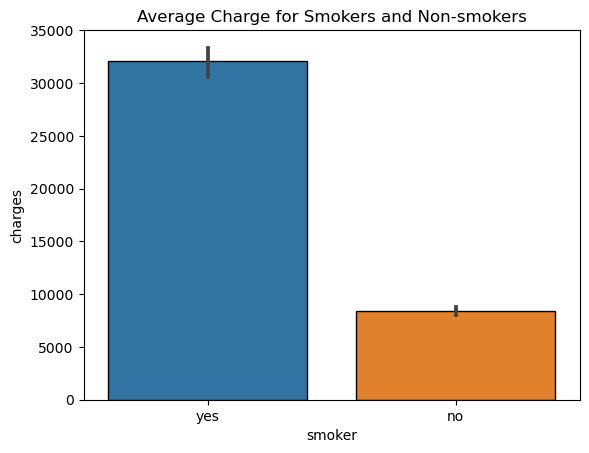

In [7]:
# Q1
sns.barplot(data = df, y = 'charges', x = 'smoker', edgecolor = 'k')
plt.title('Average Charge for Smokers and Non-smokers');

Visually, it appears that the smokers have higher charges. Let's see it this is statistically significant.

**Null hypothesis:** There is no statistical difference in charges between smokers and non-smokers

**Alternative hypothesis:** There is a statistical difference between the charges of each groups

**Significant level:** alpha = 0.05

**Selected Test:** 2 sample t-test (comparing a numerical feature between two groups)

In [29]:
# Select data for both groups
smokers = df.loc[df['smoker'] == 'yes', 'charges'].copy()
nonsmokers = df.loc[df['smoker'] == 'no', 'charges'].copy()

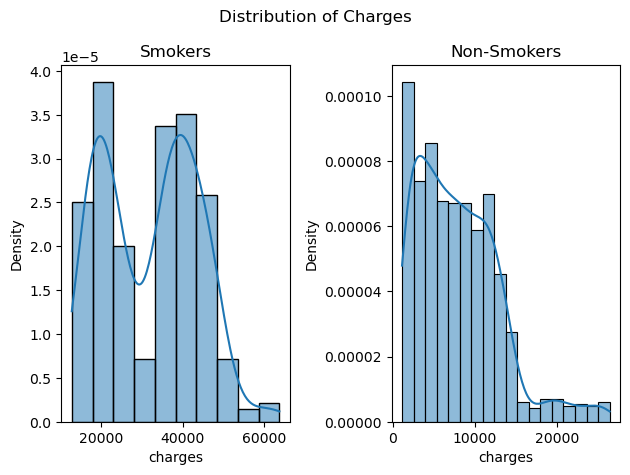

In [41]:
# histplots
fig, axes = plt.subplots(ncols = 2)
sns.histplot(smokers, ax = axes[0], stat = 'density', kde = True)
axes[0].set_title('Smokers')
sns.histplot(nonsmokers, ax = axes[1], stat = 'density', kde = True)
axes[1].set_title('Non-Smokers')
fig.suptitle('Distribution of Charges')
plt.tight_layout()

In [30]:
#check smokers
smokers = drop_outliers(smokers)

Number of instances: 274
Number of Outliers: 0


No >3 sigma outliers

In [31]:
#check nonsmokers
nonsmokers = drop_outliers(nonsmokers)

Number of instances: 1064
Number of Outliers: 24
Drop outliers (y, n):y
Number of instances after drop: 1040


Dropped 24 >3 sigma outliers

In [33]:
# check for normality
result_smokers = stats.normaltest(smokers)
print(result_smokers)
result_nonsmokers = stats.normaltest(nonsmokers)
print(result_nonsmokers)

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)
NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)


Both groups rejected the null hypothesis of the data following a normal distribution, this is because both p-values were much less than the signifance value of 0.05 (histograms also did not look normal). The data is not normal, however, the sample sizes are much larger than 15 for both groups. This was demonstrated in the during the outlier rejecting. Thus, I will continue to the hypothesis test

In [38]:
# check for equal variance
result = stats.levene(smokers, nonsmokers)
print(result)

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)


Rejected the null hypothesis of equal variance, p << 0.05. Continue but will use equal_var = False.

In [39]:
# independent t-test
tt_result = stats.ttest_ind(smokers, nonsmokers, equal_var=False)
tt_result

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)

**Interpretation:**

p-value is much smaller than alpha, thus we rejected the null hypothesis. The two groups mean charges are statistically different. Specifically, as shown in the bar plot above, the charges for smokers are higher than those of non-smokers.

## Are men more likely to smoke than women?

<AxesSubplot: xlabel='smoker', ylabel='count'>

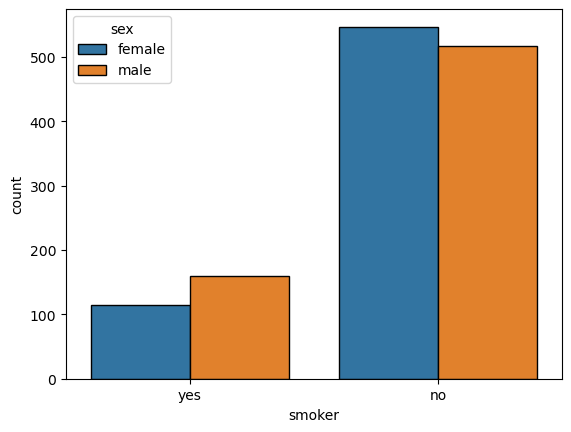

In [48]:
# visualization
sns.countplot(data = df, x = 'smoker', hue = 'sex', edgecolor = 'k')

Visual appears to show that men are slightly more likely to smoke, but is this statistically significant.

**Null hypothesis:** There is no statistical difference in the likelihood of smoking between males and females. (*Question is asking if the likelihood is different than 50%*)

**Alternative hypothesis:** There is a statistical difference between the likelihood of smoking between males and females.

**Significant level:** alpha = 0.05

**Selected Test:** chi-squared (comparing categorical feature across a categorical feature)

In [50]:
# get crosstab, or contingency table
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [52]:
# run the test and save the output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results
print(f'p-value: {p}')
if p < 0.05:
    print('Rejected null hypothesis')
else:
    print('Failed to reject null hypothesis')

p-value: 0.006548143503580696
Rejected null hypothesis


**Interpretation:**

The null hypothesis was rejected because p < alpha. This means that there a difference in the likelihood of smoking between men and women. As shown in the count plot above, men are more likely to smoke than women.

## Do difference regions have different charges, on average?

In [53]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


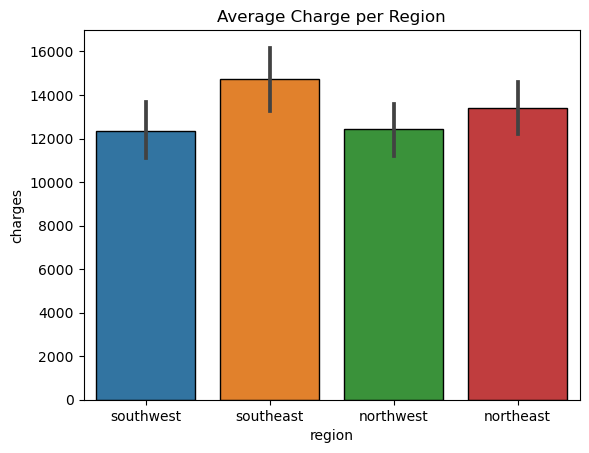

In [59]:
# Visualize averages
sns.barplot(data = df, x = 'region', y = 'charges', edgecolor = 'k')
plt.title('Average Charge per Region');

**Null hypothesis:** There is no statistical difference in charges across regions.

**Alternative hypothesis:** There is a statistical difference in charges across regions.

**Significant level:** alpha = 0.05

**Selected Test:** One-Way ANOVA (comparing numerical feature across more than 2 groups)

In [60]:
# make dictionary for each group
regions = {}

for region in df['region'].unique():
    data = df.loc[df['region']==region, 'charges'].copy()
    regions[region] = data

regions.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [61]:
# check for outliers

for key in regions:
    print(f'For region: {key}')
    regions[key] = drop_outliers(regions[key])
    print('\n')

For region: southwest
Number of instances: 325
Number of Outliers: 8
Drop outliers (y, n):y
Number of instances after drop: 317


For region: southeast
Number of instances: 364
Number of Outliers: 2
Drop outliers (y, n):y
Number of instances after drop: 362


For region: northwest
Number of instances: 325
Number of Outliers: 7
Drop outliers (y, n):y
Number of instances after drop: 318


For region: northeast
Number of instances: 324
Number of Outliers: 4
Drop outliers (y, n):y
Number of instances after drop: 320




Dropped all outliers. Note: The sample sizes are still very large.

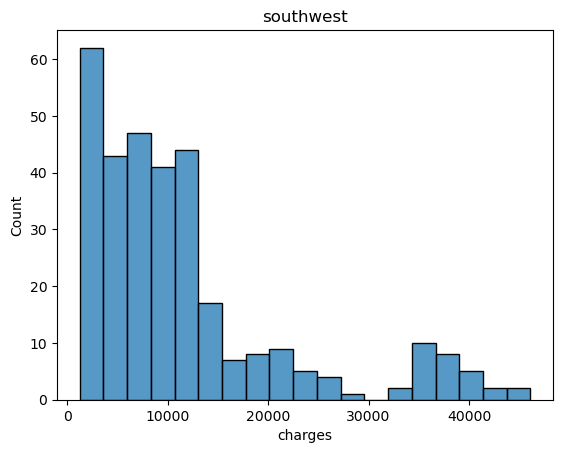

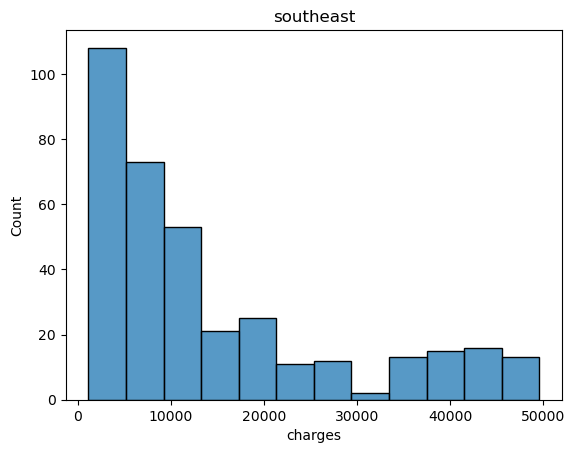

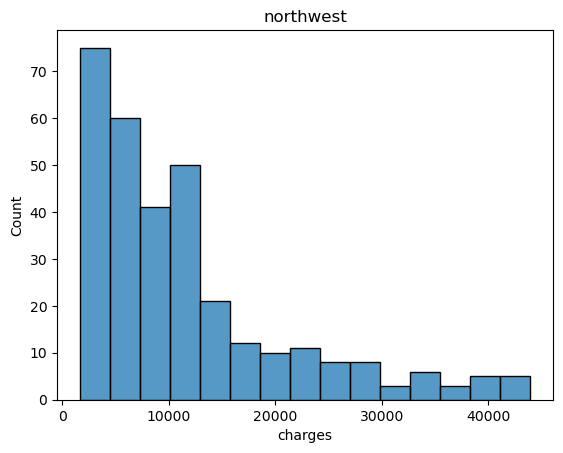

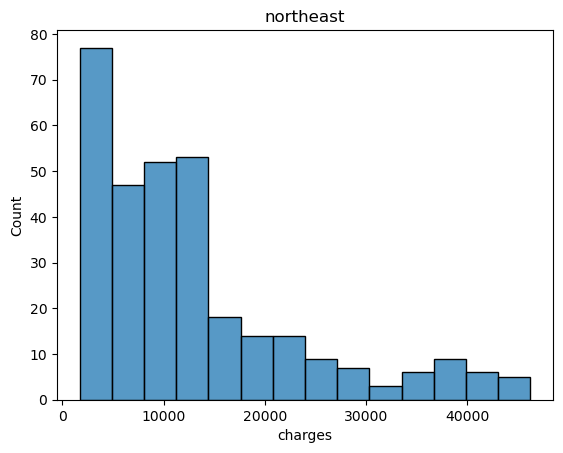

In [67]:
# visualize distributions
for region in regions:
    plt.figure()
    sns.histplot(regions[region])
    plt.title(f'{region}')

None of these distributions look to be normal.

In [66]:
# check for normality
norm_results = {}

for region, data in regions.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[region] = {'n': len(data), 'p':p, 'test stat':stat}

norm_results_df = pd.DataFrame(norm_results).T
norm_results_df  

,n,p,test stat
southwest,317.0,7.728611e-22,97.223886
southeast,362.0,1.936990e-13,58.544942
northwest,318.0,2.940543e-19,85.341045
northeast,320.0,3.557877e-17,75.749565


All of the groups rejected the null hypothesis that the distribution of charges is normal. That said, the samples sizes are much larger than 20, so we can proceed.

In [68]:
# Check for equal variance
l_results = stats.levene(*regions.values())
l_results

LeveneResult(statistic=9.518349004554441, pvalue=3.2035503711783993e-06)

The null hypothesis was rejected, the variances should not be considered equal.

In [71]:
ANOVA_result = stats.f_oneway(*regions.values())
print(ANOVA_result)
kw_result = stats.kruskal(*regions.values())
print(kw_result)

F_onewayResult(statistic=5.496394682506454, pvalue=0.0009419710075537749)
KruskalResult(statistic=6.914045702545643, pvalue=0.07468847911322242)


**Interpretation:**

The distributions did not have equal variance, thus the Kruskal-Wallis test was selected over the One-Way ANOVA (non-parametric test). *This test considers the median rather than the mean.* The p-value from this test was > 0.05, thus we failed to reject the null hypothesis which means that the medians are not significantly and statistically different. 